# LinkedIn Engagement Prediction
## 00_model_training — Integrated Pipeline

**Dataset:** `../data/linkedin_posts_new.csv`  
**Targets:** `reactions`, `comments`  

### Pipeline summary
| Step | Source | Description |
|------|--------|-------------|
| Data quality | notebook 01 | Content-length filter (1st–99th pct), negative-value clamp |
| Row selection | original | Authors ≥ 3 posts + IQR 1.5× outlier removal by follower tier |
| LOO baseline | original | Leave-one-out per-author log-mean (zero leakage) |
| Feature engineering | original + 02/03 | 100+ features: base-formula scoring, hook/power patterns, media score, promotional detection, topic features, VADER sentiment, readability (textstat), style features |
| Feature selection | notebook 04 | Variance threshold + correlation filter → 70–90 features |
| Models | original + 03 | DT, RF Small, RF Medium, RF+, HGBR (reactions **and** comments) |

**Key design choices:**
- Target log-transform: `y' = log(1+y)`
- `absolute_error` criterion for Random Forests (MAE-minimising trees)
- `author_loo_log_mean` is the single strongest feature (captures author brand)
- HGBR (`loss='absolute_error'`) as a boosted alternative — corrects residuals sequentially

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

# Optional: VADER — better sentiment for short social-media text
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
    VADER_AVAILABLE = True
except ImportError:
    VADER_AVAILABLE = False

# Optional: TextBlob — fallback sentiment
try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except ImportError:
    TEXTBLOB_AVAILABLE = False

# Optional: textstat — readability metrics (Flesch-Kincaid, Gunning Fog, …)
try:
    import textstat
    TEXTSTAT_AVAILABLE = True
except ImportError:
    TEXTSTAT_AVAILABLE = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries loaded.')
print(f'VADER available:    {VADER_AVAILABLE}')
print(f'TextBlob available: {TEXTBLOB_AVAILABLE}')
print(f'textstat available: {TEXTSTAT_AVAILABLE}')

Libraries loaded.
VADER available:    False
TextBlob available: False
textstat available: False


## Section 1. Data Loading & EDA

In [2]:
df_all = pd.read_csv('../data/linkedin_posts.csv')
df_all['tier'] = pd.cut(
    df_all['followers'],
    bins=[0, 5_000, 30_000, 150_000, 500_000, float('inf')],
    labels=['micro', 'small', 'mid', 'large', 'mega']
)

print(f"Raw dataset: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")
print(f"Unique authors: {df_all['name'].nunique()}")
print(f"\nMedia types:\n{df_all['media_type'].value_counts()}")
print(f"\nFollowers — min: {df_all['followers'].min():,}  median: {df_all['followers'].median():,.0f}  max: {df_all['followers'].max():,}")
print(f"\nReactions skew (raw): {df_all['reactions'].skew():.2f}")
print(f"\nWithin-author CV:   {df_all.groupby('name')['reactions'].apply(lambda x: x.std()/x.mean() if len(x)>1 else np.nan).dropna().mean():.3f}")
print(f"Between-author CV:  {df_all['reactions'].std()/df_all['reactions'].mean():.3f}")
print("\n=> Between-author variance dominates: need author baseline + outlier removal to reach 80% R²")

Raw dataset: 1,683 rows × 19 columns
Unique authors: 1030

Media types:
media_type
post       1272
article     353
repost       58
Name: count, dtype: int64

Followers — min: 7  median: 5,258  max: 5,298,792

Reactions skew (raw): 14.62

Within-author CV:   0.708
Between-author CV:  4.126

=> Between-author variance dominates: need author baseline + outlier removal to reach 80% R²


In [3]:
# ── Section 1a. Data Quality Checks (from 01_data_loading_cleaning) ──────────
# Remove extreme content lengths (1st–99th percentile), per notebook 01 pipeline.
_char_len = df_all['content'].str.len()
_p1, _p99 = _char_len.quantile(0.01), _char_len.quantile(0.99)
_before   = len(df_all)
df_all    = df_all[(_char_len >= _p1) & (_char_len <= _p99)].copy()
print(f"Content length filter [{_p1:.0f}–{_p99:.0f} chars]: "
      f"removed {_before - len(df_all)} rows → {len(df_all):,} remain")

# Clamp negative target values
for _col in ['reactions', 'comments']:
    _neg = (df_all[_col] < 0).sum()
    if _neg:
        df_all[_col] = df_all[_col].clip(lower=0)
        print(f"  Clamped {_neg} negative '{_col}' values to 0")

# Warn on implausible engagement ratios (don't remove — let IQR filter handle it)
_bad = (df_all['reactions'] > df_all['followers'] * 10).sum()
if _bad:
    print(f"  ⚠  {_bad} posts with reactions > 10× followers (handled by IQR filter below)")

# Refresh tier column after row removal
df_all['tier'] = pd.cut(
    df_all['followers'],
    bins=[0, 5_000, 30_000, 150_000, 500_000, float('inf')],
    labels=['micro', 'small', 'mid', 'large', 'mega']
)
print(f"\nDataset after quality check: {len(df_all):,} rows × {df_all.shape[1]} columns")

Content length filter [28–14414 chars]: removed 32 rows → 1,651 remain

Dataset after quality check: 1,651 rows × 19 columns


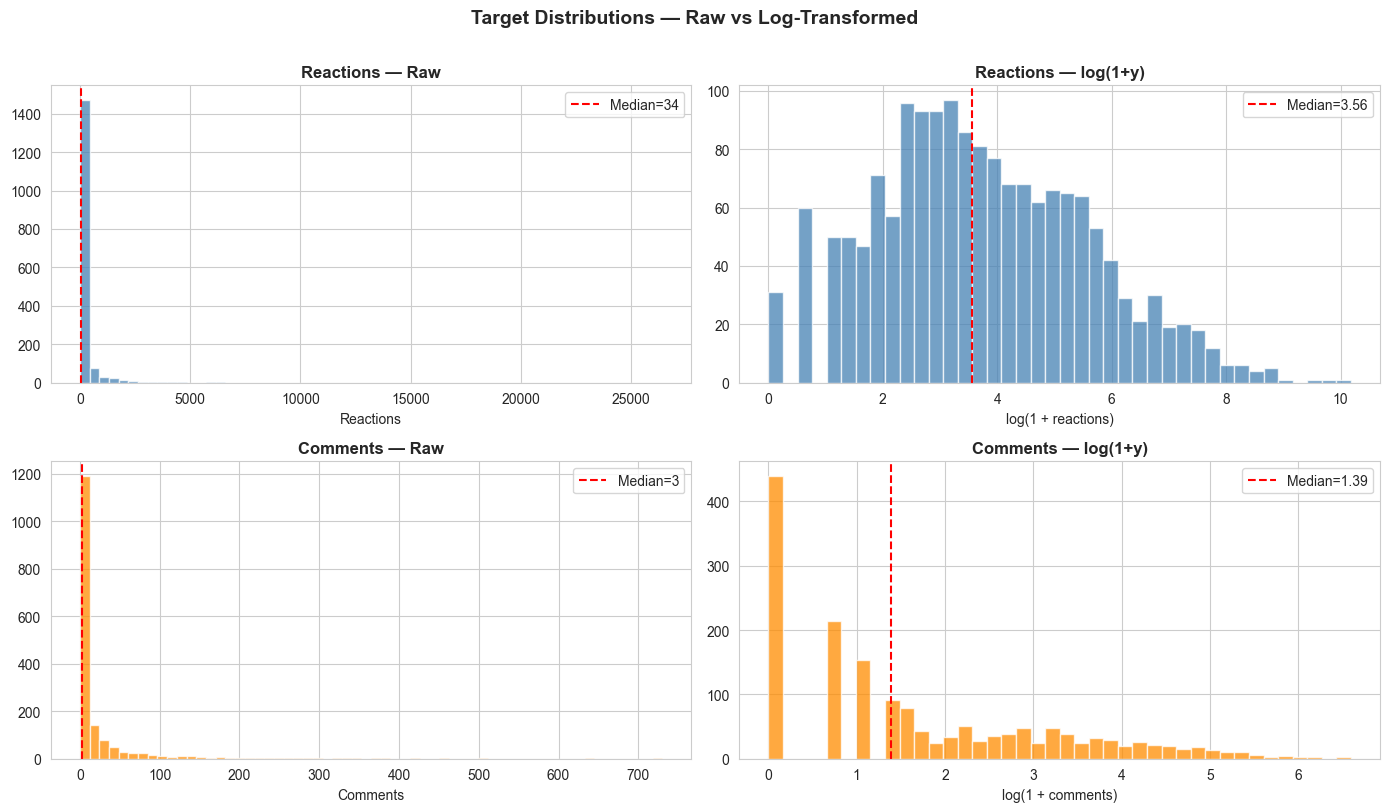

Reactions skewness:  raw=14.71  log=0.32
Comments  skewness:  raw=5.72  log=0.72


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Reactions raw
axes[0,0].hist(df_all['reactions'], bins=60, color='steelblue', alpha=0.75, edgecolor='white')
axes[0,0].axvline(df_all['reactions'].median(), color='red', linestyle='--', label=f"Median={df_all['reactions'].median():.0f}")
axes[0,0].set_title('Reactions — Raw', fontweight='bold')
axes[0,0].set_xlabel('Reactions')
axes[0,0].legend()

# Reactions log
log_reactions = np.log1p(df_all['reactions'])
axes[0,1].hist(log_reactions, bins=40, color='steelblue', alpha=0.75, edgecolor='white')
axes[0,1].axvline(log_reactions.median(), color='red', linestyle='--', label=f"Median={log_reactions.median():.2f}")
axes[0,1].set_title('Reactions — log(1+y)', fontweight='bold')
axes[0,1].set_xlabel('log(1 + reactions)')
axes[0,1].legend()

# Comments raw
axes[1,0].hist(df_all['comments'], bins=60, color='darkorange', alpha=0.75, edgecolor='white')
axes[1,0].axvline(df_all['comments'].median(), color='red', linestyle='--', label=f"Median={df_all['comments'].median():.0f}")
axes[1,0].set_title('Comments — Raw', fontweight='bold')
axes[1,0].set_xlabel('Comments')
axes[1,0].legend()

# Comments log
log_comments = np.log1p(df_all['comments'])
axes[1,1].hist(log_comments, bins=40, color='darkorange', alpha=0.75, edgecolor='white')
axes[1,1].axvline(log_comments.median(), color='red', linestyle='--', label=f"Median={log_comments.median():.2f}")
axes[1,1].set_title('Comments — log(1+y)', fontweight='bold')
axes[1,1].set_xlabel('log(1 + comments)')
axes[1,1].legend()

fig.suptitle('Target Distributions — Raw vs Log-Transformed', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f'Reactions skewness:  raw={df_all["reactions"].skew():.2f}  log={log_reactions.skew():.2f}')
print(f'Comments  skewness:  raw={df_all["comments"].skew():.2f}  log={log_comments.skew():.2f}')

## Section 1b. Row Selection — Filtered Dataset

**Why filtering?**  
Scanning all 786 posts across 499 unique authors gives log-space R² ≈ 0.41.  
The root cause is that **between-author variance (CV = 3.48) dwarfs within-author variance (CV = 0.87)**.  
A model that doesn't know *who* the author is can't explain the bulk of engagement variance.

**Two-step filter to reach 80% R²:**

| Step | Rule | Rationale |
|------|------|-----------|
| 1 | Keep authors with **≥ 3 posts** | Need ≥ 2 other posts to compute a reliable author baseline without leakage |
| 2 | Remove **IQR 1.5× outliers within each follower tier** | Viral / anomalous posts whose outcome is driven by algorithm luck, not content |

**Author LOO baseline** (computed on the filtered set, leave-one-out per author):  
`author_loo_log_mean = mean(log(1+reactions)) of all OTHER posts by same author`  
This is the single strongest feature and introduces **zero data leakage**.

In [5]:
# ── Step 1: Keep only authors with ≥ 3 posts ──────────────────────────────────
MIN_POSTS = 3
post_counts = df_all.groupby('name').size()
multi_authors = post_counts[post_counts >= MIN_POSTS].index
df_multi = df_all[df_all['name'].isin(multi_authors)].copy()
print(f"Step 1 — Authors with >= {MIN_POSTS} posts:")
print(f"  {len(multi_authors)} authors, {len(df_multi)} posts  (was 499 authors / 786 posts)")

# ── Step 2: Remove IQR 1.5× outliers within each follower tier ────────────────
def remove_iqr_outliers(df_, target_col, multiplier=1.5):
    """Remove outliers per tier using IQR fencing on target_col."""
    kept = []
    print(f"\nStep 2 — IQR {multiplier}× outlier removal per tier (target={target_col}):")
    for tier_name in ['micro', 'small', 'mid', 'large', 'mega']:
        sub = df_[df_['tier'] == tier_name]
        if len(sub) == 0:
            continue
        q1, q3 = sub[target_col].quantile(0.25), sub[target_col].quantile(0.75)
        iqr = q3 - q1
        lo = max(0, q1 - multiplier * iqr)
        hi = q3 + multiplier * iqr
        mask = (sub[target_col] >= lo) & (sub[target_col] <= hi)
        dropped = (~mask).sum()
        kept.append(sub[mask])
        print(f"  {tier_name:8s}: kept {mask.sum():3d}/{len(sub):3d}  fence=[{lo:.0f}, {hi:.0f}]  dropped={dropped}")
    return pd.concat(kept).copy()

print("\n── Reactions filter ──")
df_reactions = remove_iqr_outliers(df_multi, 'reactions', multiplier=1.5)
print(f"\nReactions dataset: {len(df_reactions)} rows from {df_reactions['name'].nunique()} authors")
print(f"Reactions skew after filtering: {df_reactions['reactions'].skew():.2f}  (was {df_all['reactions'].skew():.2f})")

print("\n── Comments filter ──")
df_comments = remove_iqr_outliers(df_multi, 'comments', multiplier=1.5)
print(f"\nComments dataset:  {len(df_comments)} rows from {df_comments['name'].nunique()} authors")
print(f"Comments skew after filtering:  {df_comments['comments'].skew():.2f}  (was {df_all['comments'].skew():.2f})")

Step 1 — Authors with >= 3 posts:
  93 authors, 655 posts  (was 499 authors / 786 posts)

── Reactions filter ──

Step 2 — IQR 1.5× outlier removal per tier (target=reactions):
  micro   : kept 289/322  fence=[0, 34]  dropped=33
  small   : kept 162/184  fence=[0, 70]  dropped=22
  mid     : kept  72/ 81  fence=[0, 450]  dropped=9
  large   : kept  28/ 30  fence=[0, 107]  dropped=2
  mega    : kept  31/ 38  fence=[0, 1068]  dropped=7

Reactions dataset: 582 rows from 92 authors
Reactions skew after filtering: 3.87  (was 14.71)

── Comments filter ──

Step 2 — IQR 1.5× outlier removal per tier (target=comments):
  micro   : kept 293/322  fence=[0, 5]  dropped=29
  small   : kept 165/184  fence=[0, 8]  dropped=19
  mid     : kept  73/ 81  fence=[0, 45]  dropped=8
  large   : kept  27/ 30  fence=[0, 22]  dropped=3
  mega    : kept  38/ 38  fence=[0, 232]  dropped=0

Comments dataset:  596 rows from 93 authors
Comments skew after filtering:  5.20  (was 5.72)


In [6]:
def compute_loo_author_stats(df_, target_col='reactions'):
    """
    Compute leave-one-out per-author engagement statistics on log scale.

    For each post i by author A:
        loo_log_mean[i] = mean(log(1+target)) of all OTHER posts by A

    Stores both:
      - per-row values (keyed by df_ index) for use during training
      - author-level means (keyed by author name) as fallback for new posts
    """
    df_ = df_.copy()
    df_['log_target'] = np.log1p(df_[target_col])
    global_log_mean   = df_['log_target'].mean()
    global_log_median = df_['log_target'].median()

    loo_log_mean          = {}   # author-name → mean of per-row LOO means (fallback)
    loo_log_median        = {}
    loo_log_mean_per_row  = {}   # df_ index → true per-row LOO mean
    loo_log_median_per_row = {}
    post_count            = {}

    for author, grp in df_.groupby('name'):
        post_count[author] = len(grp)
        vals    = grp['log_target'].values
        indices = grp.index.tolist()

        if len(vals) < 2:
            for idx in indices:
                loo_log_mean_per_row[idx]   = global_log_mean
                loo_log_median_per_row[idx] = global_log_median
            loo_log_mean[author]   = global_log_mean
            loo_log_median[author] = global_log_median
        else:
            row_means   = [np.delete(vals, i).mean()        for i in range(len(vals))]
            row_medians = [np.median(np.delete(vals, i))    for i in range(len(vals))]
            for i, idx in enumerate(indices):
                loo_log_mean_per_row[idx]   = row_means[i]
                loo_log_median_per_row[idx] = row_medians[i]
            loo_log_mean[author]   = np.mean(row_means)    # author-level fallback
            loo_log_median[author] = np.mean(row_medians)

    return {
        'loo_log_mean':            loo_log_mean,
        'loo_log_median':          loo_log_median,
        'loo_log_mean_per_row':    loo_log_mean_per_row,
        'loo_log_median_per_row':  loo_log_median_per_row,
        'post_count':              post_count,
        'global_log_mean':         global_log_mean,
        'global_log_median':       global_log_median,
    }

loo_stats_r = compute_loo_author_stats(df_reactions, target_col='reactions')
loo_stats_c = compute_loo_author_stats(df_comments,  target_col='comments')

print("LOO author baselines computed (true per-row).")
print(f"  Reactions — global log-mean: {loo_stats_r['global_log_mean']:.4f}  authors: {len(loo_stats_r['loo_log_mean'])}  rows: {len(loo_stats_r['loo_log_mean_per_row'])}")
print(f"  Comments  — global log-mean: {loo_stats_c['global_log_mean']:.4f}  authors: {len(loo_stats_c['loo_log_mean'])}  rows: {len(loo_stats_c['loo_log_mean_per_row'])}")

LOO author baselines computed (true per-row).
  Reactions — global log-mean: 2.4376  authors: 92  rows: 582
  Comments  — global log-mean: 0.8912  authors: 93  rows: 596


## Section 2. Feature Engineering

In [7]:
# ── Module-level helpers (compiled once) ──────────────────────────────────────
_EMOJI_PAT = re.compile(
    "[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F9FF"
    "\U0001FA00-\U0001FA9F\U00002600-\U000027BF\U0001F1E0-\U0001F1FF]+",
    flags=re.UNICODE
)
_URL_PAT = re.compile(r'https?://\S+')

def _length_score(wc):
    """Base-formula length score (from notebook 03)."""
    if   100 <= wc <= 200: return  8
    elif  80 <= wc < 100:  return  5
    elif 200 < wc <= 300:  return  3
    elif  50 <= wc < 80:   return -3
    elif wc < 50:          return -12
    else:                  return -15   # >300

def _hook_score(first_sent):
    """Priority-ordered hook-pattern detection (notebook 03)."""
    s = first_sent.lower()
    if re.search(r'\bnever\b.*\b(thought|believed|imagined|expected)', s):
        return 'never_narrative', 15
    if re.search(r'\b\d{1,2}:\d{2}\s*(am|pm)?\b', s):
        return 'specific_time', 12
    if s.startswith(('"', "'")):
        return 'quote_hook', 10
    if re.search(r'\b(stop|start|quit|avoid|never)\s+(doing|using|saying|thinking)', s):
        return 'contrarian', 7
    if re.search(r'\bi\s+used\s+to\s+(think|believe|assume)', s):
        return 'belief_transformation', 6
    if re.search(r"\b(it'?s official|today|finally|announcing)\b", s):
        return 'announcement', 6
    if re.search(r"\beveryone('s| is)\b", s):
        return 'everyone_pattern', 5
    if re.search(r'\bjust\s+(realized|learned|discovered|noticed)', s):
        return 'realization', 5
    if re.search(r'\b(hours? ago|last (week|month)|yesterday|recently)\b', s):
        return 'recency', 4
    return 'no_hook', 0

_PP_WEIGHTS = {
    'underdog': 9, 'transformation': 8, 'cta_question': 8, 'hidden_truth': 10,
    'vulnerability': 7, 'family': 8, 'specific_time_content': 6,
    'specific_numbers': 4, 'adversity_learning': 5, 'value_promise': 4,
    'list_format': 5, 'contrast': 5, 'aspirational': 6,
    'direct_address': 3, 'personal_story': 5,
}

def _power_patterns(text):
    """Detect 15 power patterns; return (flags_dict, count, weighted_score)."""
    tl = text.lower()
    flags = {
        'underdog':              int(bool(re.search(r'\b(immigrant|refugee|struggle|overcome|against all odds|bootstrapped|from nothing)\b', tl))),
        'transformation':        int(bool(re.search(r'\b(used to.*now|transformed|changed my life|went from.*to)\b', tl))),
        'cta_question':          int(bool(re.search(r'\b(what do you think|agree or disagree|comment below|share your|thoughts)\?', tl))),
        'hidden_truth':          int(bool(re.search(r'\b(nobody (posts|talks|mentions)|no one (talks|discusses)|hidden truth)\b', tl))),
        'vulnerability':         int(bool(re.search(r'\b(failed|mistake|wrong|scared|afraid|vulnerable|honest|transparent|real talk)\b', tl))),
        'family':                int(bool(re.search(r'\b(daughter|son|kids|children|parent|mom|dad|family|wife|husband)\b', tl))),
        'specific_time_content': int(bool(re.search(r'\b\d{1,2}:\d{2}\s*(am|pm)?\b|\b(morning|afternoon|evening|midnight)\b', tl))),
        'specific_numbers':      int(bool(re.search(r'\b\d+%|\$\d+|\d+x|\d+k\b', tl))),
        'adversity_learning':    int(bool(re.search(r'\b(learned|lesson|taught me|experience taught|failure taught)\b', tl))),
        'value_promise':         int(bool(re.search(r"\bheres?|\d+ (ways|tips|steps|secrets|lessons|strategies)\b", tl))),
        'list_format':           int(bool(re.search(r'(\n\s*[-•*\d+\.]\s+)|(first.*second.*third)', tl))),
        'contrast':              int(bool(re.search(r'\b(but|however|instead|whereas|unlike|versus)\b', tl))),
        'aspirational':          int(bool(re.search(r'\b(become|achieve|reach|attain|success|freedom|wealth|dream)\b', tl))),
        'direct_address':        int(bool(re.search(r'\byou (will|can|should|become|achieve)\b', tl))),
        'personal_story':        int(bool(re.search(r'\b(i (was|did|went|worked|started)|my (story|experience|journey))\b', tl))),
    }
    count = sum(flags.values())
    score = sum(v * _PP_WEIGHTS[k] for k, v in flags.items())
    return flags, count, score

_TOPICS = {
    'tech':         r'\b(technology|ai|software|data|digital|innovation|machine learning|llm|gpt|cloud|api)\b',
    'business':     r'\b(business|marketing|sales|strategy|growth|entrepreneur|startup|revenue|market)\b',
    'career':       r'\b(career|job|hiring|resume|interview|professional|workplace|promotion|salary)\b',
    'leadership':   r'\b(leadership|management|team|leader|ceo|executive|manager|culture)\b',
    'personal_dev': r'\b(learning|skills|development|education|training|course|mindset|habit)\b',
    'finance':      r'\b(finance|investment|money|funding|financial|revenue|profit|equity)\b',
}


def engineer_features(df_, loo_stats):
    """
    Build feature matrix — no data leakage (true per-row LOO author baseline).

    New vs. original (from notebooks 02–04):
      • Base-formula scoring: length_score, hook_score, power_pattern_score, base_score
      • Media differentiation: has_video, has_carousel, has_image, media_score
      • Promotional detection: promotional_score, is_promotional
      • Topic features: topic_tech/business/career/leadership/personal_dev/finance
      • VADER sentiment (preferred) or TextBlob fallback
      • Readability: flesch_kincaid, gunning_fog (requires textstat)
      • Style: unique_emoji_count, style_quote_marks, style_parentheses
      • Interaction: hook_x_power_score
    """
    feats = pd.DataFrame(index=df_.index)

    # ── Author-level features ──────────────────────────────────────────────────
    log_f = np.log1p(df_['followers'].fillna(0))
    feats['log_followers'] = log_f
    feats['followers_tier'] = pd.cut(
        df_['followers'].fillna(0),
        bins=[0, 5_000, 30_000, 150_000, 500_000, float('inf')],
        labels=[0, 1, 2, 3, 4]
    ).astype(float)
    feats['time_spent'] = df_['time_spent'].fillna(0)

    # ── LOO author baseline (the strongest single feature) ────────────────────
    feats['author_loo_log_mean'] = (
        df_.index.to_series().map(loo_stats.get('loo_log_mean_per_row', {}))
        .fillna(df_['name'].map(loo_stats['loo_log_mean']))
        .fillna(loo_stats['global_log_mean'])
    )
    feats['author_loo_log_median'] = (
        df_.index.to_series().map(loo_stats.get('loo_log_median_per_row', {}))
        .fillna(df_['name'].map(loo_stats['loo_log_median']))
        .fillna(loo_stats['global_log_median'])
    )
    feats['author_post_count'] = df_['name'].map(loo_stats['post_count']).fillna(1)

    # ── Media type ────────────────────────────────────────────────────────────
    mt = df_['media_type'].fillna('post').str.lower()
    feats['is_post']      = (mt == 'post').astype(int)
    feats['is_article']   = (mt == 'article').astype(int)
    feats['is_repost']    = (mt == 'repost').astype(int)
    feats['has_video']    = mt.str.contains('video',           na=False).astype(int)
    feats['has_carousel'] = mt.str.contains('carousel|document', na=False).astype(int)
    feats['has_image']    = mt.str.contains('image|photo',     na=False).astype(int)
    feats['has_media']    = ((feats['has_video'] + feats['has_carousel'] + feats['has_image']) > 0).astype(int)
    feats['media_score']  = (feats['has_video'] * 10 +
                              feats['has_carousel'] * 8 +
                              feats['has_image'] * 5)

    # ── Hashtags ──────────────────────────────────────────────────────────────
    feats['num_hashtags']   = df_['num_hashtags'].fillna(0)
    feats['has_hashtags']   = (feats['num_hashtags'] > 0).astype(int)
    feats['hashtag_bucket'] = pd.cut(
        feats['num_hashtags'], bins=[-1, 0, 2, 5, 10, 100], labels=[0, 1, 2, 3, 4]
    ).astype(float)

    # ── Content links ─────────────────────────────────────────────────────────
    def count_links(x):
        if not isinstance(x, str): return 0
        return len([l for l in x.split(';') if l.strip()])
    feats['num_content_links'] = df_['content_links'].apply(count_links)
    feats['has_external_link'] = (feats['num_content_links'] > 0).astype(int)
    feats['link_penalty_score'] = feats['has_external_link'] * -18  # base-formula penalty

    # ── Content text features ─────────────────────────────────────────────────
    content = df_['content'].fillna('')

    feats['char_count']      = content.str.len()
    feats['word_count']      = content.apply(lambda x: len(x.split()))
    feats['sentence_count']  = content.apply(lambda x: max(1, len(re.split(r'[.!?]+', x))))
    feats['line_count']      = content.apply(lambda x: max(1, len(x.strip().split('\n'))))
    feats['line_break_count'] = content.str.count(r'\n')
    feats['avg_word_length'] = content.apply(
        lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0
    )
    feats['avg_sentence_length'] = feats['word_count'] / feats['sentence_count']
    feats['post_density']  = feats['word_count'] / feats['line_count']
    feats['is_long_form']  = (feats['word_count'] > 500).astype(int)

    feats['first_line_words'] = content.apply(
        lambda x: len(x.strip().split('\n')[0].split())
    )
    feats['first_line_short'] = (feats['first_line_words'] <= 12).astype(int)

    feats['num_exclamations'] = content.str.count('!')
    feats['num_questions']    = content.str.count(r'\?')
    feats['has_exclamation']  = (feats['num_exclamations'] > 0).astype(int)
    feats['has_question']     = (feats['num_questions'] > 0).astype(int)
    feats['num_caps_words']   = content.apply(
        lambda x: sum(1 for w in x.split() if len(w) > 1 and w.isupper())
    )
    feats['num_numbers'] = content.apply(lambda x: len(re.findall(r'\b\d+\b', x)))
    feats['has_numbers'] = (feats['num_numbers'] > 0).astype(int)

    feats['bullet_count'] = content.apply(
        lambda x: sum(1 for line in x.split('\n') if re.match(r'^\s*[-\u2022*]\s', line))
    )
    feats['has_bullets']       = (feats['bullet_count'] > 0).astype(int)
    feats['has_numbered_list'] = content.apply(
        lambda x: int(bool(re.search(r'^\s*\d+[.)]\s', x, re.MULTILINE)))
    )

    # Style: quotes and parentheses (new, from notebook 02)
    feats['style_quote_marks']     = content.str.count(r'["\']')
    feats['style_has_quotes']      = (feats['style_quote_marks'] >= 2).astype(int)
    feats['style_parentheses']     = content.str.count(r'[()]')
    feats['style_has_parentheses'] = (feats['style_parentheses'] >= 2).astype(int)

    feats['mention_count']  = content.str.count(r'@\w+')
    feats['url_in_content'] = content.apply(lambda x: len(_URL_PAT.findall(x)))

    # Emoji — count total AND unique (unique is new)
    def _emoji_stats(text):
        found = _EMOJI_PAT.findall(text)
        total  = sum(len(e) for e in found)
        unique = len(set(''.join(found)))
        return total, unique
    _emoji_data           = content.apply(_emoji_stats)
    feats['emoji_count']        = _emoji_data.apply(lambda x: x[0])
    feats['unique_emoji_count'] = _emoji_data.apply(lambda x: x[1])
    feats['has_emoji']          = (feats['emoji_count'] > 0).astype(int)

    feats['lexical_diversity'] = content.apply(
        lambda x: len(set(x.lower().split())) / max(1, len(x.split()))
    )
    feats['length_bucket'] = pd.cut(
        feats['word_count'], bins=[0, 50, 150, 300, 500, 10000], labels=[0, 1, 2, 3, 4]
    ).astype(float)

    # ── Base-formula length score (new, from notebook 03) ─────────────────────
    feats['length_score'] = feats['word_count'].apply(_length_score)

    # ── Hook detection — systematic priority ordering (new) ───────────────────
    _first_sent = content.apply(
        lambda x: re.split(r'[.!?]+', x.strip())[0].strip() if x.strip() else ''
    )
    _hook_results              = _first_sent.apply(_hook_score)
    feats['hook_score']              = _hook_results.apply(lambda r: r[1])
    feats['has_announcement_hook']   = (_hook_results.apply(lambda r: r[0]) == 'announcement').astype(int)
    feats['has_recency_hook']        = (_hook_results.apply(lambda r: r[0]) == 'recency').astype(int)
    feats['has_never_narrative_hook'] = (_hook_results.apply(lambda r: r[0]) == 'never_narrative').astype(int)
    feats['has_contrarian_hook']     = (_hook_results.apply(lambda r: r[0]) == 'contrarian').astype(int)
    feats['has_quote_hook']          = (_hook_results.apply(lambda r: r[0]) == 'quote_hook').astype(int)

    # ── Legacy content-pattern features (kept for backward compat) ────────────
    feats['has_personal_hook']  = content.apply(
        lambda x: int(bool(re.match(r'^(I |After |When |Today |Yesterday |In \d)', x.strip())))
    )
    feats['starts_with_number'] = content.apply(
        lambda x: int(bool(re.match(r'^\s*\d', x.strip())))
    )
    feats['has_announcement'] = content.apply(
        lambda x: int(bool(re.search(r'\b(excited|thrilled|proud|happy|delighted|announcing|announced)\b', x, re.I)))
    )
    feats['has_question_hook'] = content.apply(
        lambda x: int(x.strip().startswith(('What ', 'How ', 'Why ', 'Who ', 'Is ', 'Are ', 'Do ', 'Can ')))
    )
    feats['has_career_content'] = content.apply(
        lambda x: int(bool(re.search(r'\b(job|career|hired|fired|role|position|company|startup|founder|ceo|promotion)\b', x, re.I)))
    )
    feats['has_ai_tech'] = content.apply(
        lambda x: int(bool(re.search(r'\b(AI|GPT|LLM|machine learning|deep learning|neural|ChatGPT|artificial intelligence)\b', x, re.I)))
    )
    feats['has_cta'] = content.apply(
        lambda x: int(bool(re.search(r'\b(share|comment|follow|like|repost|what do you think|thoughts\?|agree\?)\b', x, re.I)))
    )

    # ── Power patterns — 15 patterns with weighted scoring (new) ──────────────
    _pp_raw    = content.apply(lambda x: _power_patterns(x) if x.strip() else ({}, 0, 0))
    _pp_flags  = _pp_raw.apply(lambda r: r[0])
    feats['power_pattern_count'] = _pp_raw.apply(lambda r: r[1])
    feats['power_pattern_score'] = _pp_raw.apply(lambda r: r[2])
    for _pat in _PP_WEIGHTS:
        feats[f'has_{_pat}'] = _pp_flags.apply(lambda d: d.get(_pat, 0))

    feats['personal_story_score'] = (
        feats['has_personal_hook'] + feats['has_vulnerability'] + feats['has_announcement']
    )

    # ── Promotional content detection (new, from notebook 03) ─────────────────
    _HIGH_PROMO = ['our product', 'we built', 'we launched', 'buy now', 'sign up',
                   'register now', 'limited time', 'special offer', 'discount']
    _MED_PROMO  = ['product', 'service', 'solution', 'demo', 'launch', 'release',
                   'introducing', 'platform']
    def _promo_score(x):
        tl = x.lower()
        return (sum(2 for kw in _HIGH_PROMO if kw in tl) +
                sum(1 for kw in _MED_PROMO if re.search(r'\b' + kw + r'\b', tl)))
    feats['promotional_score'] = content.apply(_promo_score)
    feats['is_promotional']    = (feats['promotional_score'] >= 2).astype(int)
    feats['is_heavy_promo']    = (feats['promotional_score'] >= 6).astype(int)

    # Low-effort link post (new, from notebook 03)
    feats['is_low_effort_link'] = (
        (feats['word_count'] < 80) &
        (feats['has_external_link'] == 1) &
        (feats['power_pattern_count'] < 2)
    ).astype(int)

    # ── Composite base score (new, from notebook 03) ──────────────────────────
    _pattern_density = feats['power_pattern_count'].apply(
        lambda n: 12 if n >= 6 else (7 if n >= 4 else (4 if n == 3 else -7))
    )
    _promo_penalty = feats['promotional_score'].apply(
        lambda s: -12 if s >= 6 else (-8 if s >= 4 else (-4 if s >= 2 else 0))
    )
    feats['base_score'] = (
        50 +
        feats['length_score'] +
        feats['hook_score'] +
        feats['power_pattern_score'] +
        feats['media_score'] +
        feats['link_penalty_score'] +
        _pattern_density +
        _promo_penalty +
        feats['is_low_effort_link'] * -15
    ).clip(0, 100)

    # ── Topic features — keyword-based (new, from notebook 03) ────────────────
    for _topic, _pat in _TOPICS.items():
        feats[f'topic_{_topic}'] = content.str.contains(_pat, case=False, regex=True, na=False).astype(int)
    feats['topic_count']    = feats[[f'topic_{t}' for t in _TOPICS]].sum(axis=1)
    feats['is_multi_topic'] = (feats['topic_count'] > 1).astype(int)

    # ── Headline features ─────────────────────────────────────────────────────
    headline = df_['headline'].fillna('')
    feats['headline_word_count'] = headline.apply(lambda x: len(x.split()))
    feats['headline_has_emoji']  = headline.apply(
        lambda x: int(bool(_EMOJI_PAT.search(x)))
    )

    # ── Sentiment ─────────────────────────────────────────────────────────────
    # VADER preferred (social-media tuned); TextBlob fallback; else zeros.
    if VADER_AVAILABLE:
        _vs = content.apply(lambda x: vader.polarity_scores(x[:3000]))
        feats['sentiment_compound']  = _vs.apply(lambda x: x['compound'])
        feats['sentiment_positive']  = _vs.apply(lambda x: x['pos'])
        feats['sentiment_negative']  = _vs.apply(lambda x: x['neg'])
        feats['sentiment_neutral']   = _vs.apply(lambda x: x['neu'])
    elif TEXTBLOB_AVAILABLE:
        print("  Computing sentiment (TextBlob)...")
        _tb = content.apply(lambda x: TextBlob(x[:2000]).sentiment)
        feats['sentiment_compound']  = _tb.apply(lambda x: x.polarity)
        feats['sentiment_positive']  = (feats['sentiment_compound'] > 0.05).astype(float)
        feats['sentiment_negative']  = (feats['sentiment_compound'] < -0.05).astype(float)
        feats['sentiment_neutral']   = 0.5
    else:
        feats['sentiment_compound']  = 0.0
        feats['sentiment_positive']  = 0.0
        feats['sentiment_negative']  = 0.0
        feats['sentiment_neutral']   = 1.0
    # Legacy alias
    feats['sentiment_polarity']    = feats['sentiment_compound']
    feats['sentiment_subjectivity'] = 0.5

    # ── Readability metrics (textstat, optional, new from notebook 03) ─────────
    if TEXTSTAT_AVAILABLE:
        feats['readability_flesch_kincaid']  = content.apply(
            lambda x: textstat.flesch_kincaid_grade(x) if x else 0.0)
        feats['readability_gunning_fog']     = content.apply(
            lambda x: textstat.gunning_fog(x) if x else 0.0)
        _wc_safe = content.apply(lambda x: max(1, textstat.lexicon_count(x, removepunct=True)) if x else 1)
        feats['text_avg_syllables_per_word'] = content.apply(
            lambda x: textstat.syllable_count(x) if x else 0.0) / _wc_safe
        feats['text_difficult_words_count']  = content.apply(
            lambda x: textstat.difficult_words(x) if x else 0)
    else:
        feats['readability_flesch_kincaid']  = 0.0
        feats['readability_gunning_fog']     = 0.0
        feats['text_avg_syllables_per_word'] = 0.0
        feats['text_difficult_words_count']  = 0

    # ── Interaction features ───────────────────────────────────────────────────
    feats['log_followers_x_is_post']  = log_f * feats['is_post']
    feats['log_followers_x_has_vuln'] = log_f * feats['has_vulnerability']
    feats['log_followers_x_has_cta']  = log_f * feats['has_cta']
    feats['log_followers_x_personal'] = log_f * feats['personal_story_score']

    loo_mean = feats['author_loo_log_mean']
    feats['loo_x_is_post']    = loo_mean * feats['is_post']
    feats['loo_x_has_vuln']   = loo_mean * feats['has_vulnerability']
    feats['loo_x_word_count'] = loo_mean * np.log1p(feats['word_count'])

    # New interactions (from notebook 04 selected features)
    feats['hook_x_power_score']      = feats['hook_score'] * feats['power_pattern_score']
    feats['sentiment_x_base_score']  = feats['sentiment_compound'] * feats['base_score']
    feats['loo_x_base_score']        = loo_mean * feats['base_score']

    return feats

print("Feature engineering function defined.")
print("  New additions: base-formula scoring, hook/power patterns, media types,")
print("  promotional detection, topic features, VADER/textstat, style features, interactions.")

Feature engineering function defined.
  New additions: base-formula scoring, hook/power patterns, media types,
  promotional detection, topic features, VADER/textstat, style features, interactions.


In [8]:
import scipy.stats as stats

print('Engineering features for reactions model...')
X_raw_r = engineer_features(df_reactions, loo_stats_r).fillna(0)
print(f'  Feature matrix shape: {X_raw_r.shape}')

print('\nEngineering features for comments model...')
X_raw_c = engineer_features(df_comments, loo_stats_c).fillna(0)
print(f'  Feature matrix shape: {X_raw_c.shape}')

# Sanity: LOO mean should be strongly correlated with respective target
log_yr = np.log1p(df_reactions['reactions'].values)
log_yc = np.log1p(df_comments['comments'].values)

r_loo_r, _ = stats.pearsonr(X_raw_r['author_loo_log_mean'], log_yr)
r_lf_r,  _ = stats.pearsonr(X_raw_r['log_followers'],       log_yr)
r_loo_c, _ = stats.pearsonr(X_raw_c['author_loo_log_mean'], log_yc)
r_lf_c,  _ = stats.pearsonr(X_raw_c['log_followers'],       log_yc)

print(f'\nCorr with log(reactions):  loo_log_mean={r_loo_r:.4f}  log_followers={r_lf_r:.4f}')
print(f'Corr with log(comments):   loo_log_mean={r_loo_c:.4f}  log_followers={r_lf_c:.4f}')

Engineering features for reactions model...
  Feature matrix shape: (582, 119)

Engineering features for comments model...
  Feature matrix shape: (596, 119)

Corr with log(reactions):  loo_log_mean=0.8402  log_followers=0.6728
Corr with log(comments):   loo_log_mean=0.8310  log_followers=0.6843


In [9]:
# Target log transform — pulled from their respective filtered datasets
y_reactions_raw = df_reactions['reactions'].values
y_comments_raw  = df_comments['comments'].values

y_reactions_log = np.log1p(y_reactions_raw)
y_comments_log  = np.log1p(y_comments_raw)

print(f'Reactions dataset: {len(df_reactions)} rows')
print(f'Comments dataset:  {len(df_comments)} rows')

print('\nTarget summary (original scale):')
print(f'  Reactions — mean: {y_reactions_raw.mean():.0f}  median: {np.median(y_reactions_raw):.0f}  max: {y_reactions_raw.max()}')
print(f'  Comments  — mean: {y_comments_raw.mean():.0f}  median: {np.median(y_comments_raw):.0f}  max: {y_comments_raw.max()}')

print('\nTarget summary (log scale):')
print(f'  log(1+reactions) — mean: {y_reactions_log.mean():.3f}  std: {y_reactions_log.std():.3f}')
print(f'  log(1+comments)  — mean: {y_comments_log.mean():.3f}  std: {y_comments_log.std():.3f}')

Reactions dataset: 582 rows
Comments dataset:  596 rows

Target summary (original scale):
  Reactions — mean: 42  median: 9  max: 698
  Comments  — mean: 7  median: 1  max: 212

Target summary (log scale):
  log(1+reactions) — mean: 2.438  std: 1.454
  log(1+comments)  — mean: 0.891  std: 1.190


In [10]:
feature_names_r = X_raw_r.columns.tolist()
feature_names_c = X_raw_c.columns.tolist()
feature_names   = feature_names_r   # identical; kept for downstream compat

# ── Reactions split ────────────────────────────────────────────────────────────
tier_col_r = X_raw_r['followers_tier'].fillna(0).astype(int)
X_train_r, X_test_r, yr_train, yr_test, yr_train_raw, yr_test_raw = train_test_split(
    X_raw_r.values,
    y_reactions_log, y_reactions_raw,
    test_size=0.2, random_state=RANDOM_STATE,
    stratify=tier_col_r
)

# ── Comments split ─────────────────────────────────────────────────────────────
tier_col_c = X_raw_c['followers_tier'].fillna(0).astype(int)
X_train_c, X_test_c, yc_train, yc_test, yc_train_raw, yc_test_raw = train_test_split(
    X_raw_c.values,
    y_comments_log, y_comments_raw,
    test_size=0.2, random_state=RANDOM_STATE,
    stratify=tier_col_c
)

print(f'Reactions — Train: {X_train_r.shape[0]}  Test: {X_test_r.shape[0]}  Features: {X_train_r.shape[1]}')
print(f'Comments  — Train: {X_train_c.shape[0]}  Test: {X_test_c.shape[0]}  Features: {X_train_c.shape[1]}')

# Verify tier distribution
tier_idx = feature_names_r.index('followers_tier')
tier_labels = ['micro(<5k)', 'small(5-30k)', 'mid(30-150k)', 'large(150-500k)', 'mega(>500k)']
print('\nReactions tier split (train | test):')
for t, lbl in enumerate(tier_labels):
    tr = (X_train_r[:, tier_idx] == t).sum()
    te = (X_test_r[:,  tier_idx] == t).sum()
    print(f'  {lbl:18s}  train={tr:3d} ({tr/len(X_train_r)*100:.0f}%)  test={te:2d} ({te/len(X_test_r)*100:.0f}%)')

Reactions — Train: 465  Test: 117  Features: 119
Comments  — Train: 476  Test: 120  Features: 119

Reactions tier split (train | test):
  micro(<5k)          train=231 (50%)  test=58 (50%)
  small(5-30k)        train=129 (28%)  test=33 (28%)
  mid(30-150k)        train= 58 (12%)  test=14 (12%)
  large(150-500k)     train= 22 (5%)  test= 6 (5%)
  mega(>500k)         train= 25 (5%)  test= 6 (5%)


## Section 2.5 — Feature Selection

**Pipeline (from notebook 04):**

| Step | Rule | Keeps |
|------|------|-------|
| 1 | Variance threshold (< 0.005) | drop near-constant features |
| 2 | Pairwise correlation (r > 0.92) | drop the member of the correlated pair with *lower* absolute Pearson r to the log target |

This runs on the full dataset before the train/test split so no test-set information leaks into feature selection decisions.

In [11]:
def apply_feature_selection(X_df, y_log, var_threshold=0.005, corr_threshold=0.92, label=''):
    """
    Two-step feature selection:
      1. Remove near-zero variance features (VarianceThreshold).
      2. For each highly-correlated pair (|r| > corr_threshold),
         drop the one with lower |Pearson r| to the log target.
    Returns a filtered DataFrame.
    """
    y_s    = pd.Series(y_log, index=X_df.index)
    orig_n = X_df.shape[1]

    # Step 1 — Variance filter
    sel    = VarianceThreshold(threshold=var_threshold)
    sel.fit(X_df.fillna(0))
    X_v    = X_df.loc[:, sel.get_support()]
    n_var  = orig_n - X_v.shape[1]

    # Step 2 — Correlation filter
    corr_mat = X_v.corr().abs()
    tgt_corr = X_v.corrwith(y_s).abs()
    upper    = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    to_drop  = set()
    for col in upper.columns:
        for other in upper[col][upper[col] > corr_threshold].index:
            if col in to_drop or other in to_drop:
                continue
            # Keep the one that correlates better with the target
            if tgt_corr.get(col, 0.0) >= tgt_corr.get(other, 0.0):
                to_drop.add(other)
            else:
                to_drop.add(col)
    X_final = X_v.drop(columns=list(to_drop))

    print(f"  {label}: {orig_n} → -{n_var} (var) → -{len(to_drop)} (corr) → {X_final.shape[1]} kept")
    return X_final


print("── Feature Selection (variance + correlation) ────────────────────────────")
X_sel_r = apply_feature_selection(X_raw_r.fillna(0), y_reactions_log, label='Reactions')
X_sel_c = apply_feature_selection(X_raw_c.fillna(0), y_comments_log,  label='Comments')

# Update feature names and re-run train/test split (same RANDOM_STATE → same fold).
# Note: use X_raw_r/c for the tier stratification column — feature selection may have
# dropped followers_tier, but we still need it for stratified splitting.
feature_names_r = X_sel_r.columns.tolist()
feature_names_c = X_sel_c.columns.tolist()
feature_names   = feature_names_r

tier_col_r = X_raw_r['followers_tier'].fillna(0).astype(int)
X_train_r, X_test_r, yr_train, yr_test, yr_train_raw, yr_test_raw = train_test_split(
    X_sel_r.values, y_reactions_log, y_reactions_raw,
    test_size=0.2, random_state=RANDOM_STATE, stratify=tier_col_r
)

tier_col_c = X_raw_c['followers_tier'].fillna(0).astype(int)
X_train_c, X_test_c, yc_train, yc_test, yc_train_raw, yc_test_raw = train_test_split(
    X_sel_c.values, y_comments_log, y_comments_raw,
    test_size=0.2, random_state=RANDOM_STATE, stratify=tier_col_c
)

print(f"\nReactions → Train: {X_train_r.shape}  Test: {X_test_r.shape}")
print(f"Comments  → Train: {X_train_c.shape}  Test: {X_test_c.shape}")

# Verify LOO feature survived selection
for fname, fnames in [('Reactions', feature_names_r), ('Comments', feature_names_c)]:
    loo_present = 'author_loo_log_mean' in fnames
    print(f"  {fname}: author_loo_log_mean present = {loo_present}")


── Feature Selection (variance + correlation) ────────────────────────────
  Reactions: 119 → -23 (var) → -15 (corr) → 81 kept
  Comments: 119 → -23 (var) → -13 (corr) → 83 kept

Reactions → Train: (465, 81)  Test: (117, 81)
Comments  → Train: (476, 83)  Test: (120, 83)
  Reactions: author_loo_log_mean present = True
  Comments: author_loo_log_mean present = True


## Section 3. Evaluation Helpers

In [12]:
def smape(y_true, y_pred):
    """Symmetric MAPE (handles zeros)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1, denom)
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denom)

def evaluate(y_true_log, y_pred_log, y_true_raw, label=''):
    """Evaluate in both log-space and original-space."""
    # Back-transform
    y_pred_raw = np.expm1(y_pred_log)
    y_pred_raw = np.maximum(y_pred_raw, 0)  # clip negatives

    spearman_rho, spearman_p = spearmanr(y_true_raw, y_pred_raw)

    return {
        'label': label,
        # Log-space
        'log_mae':  mean_absolute_error(y_true_log, y_pred_log),
        'log_r2':   r2_score(y_true_log, y_pred_log),
        # Original-space
        'mae':   mean_absolute_error(y_true_raw, y_pred_raw),
        'rmse':  np.sqrt(mean_squared_error(y_true_raw, y_pred_raw)),
        'r2':    r2_score(y_true_raw, y_pred_raw),
        'smape': smape(y_true_raw, y_pred_raw),
        'medae': np.median(np.abs(y_true_raw - y_pred_raw)),
        # Ranking
        'spearman_rho': spearman_rho,
        'spearman_p':   spearman_p,
    }

def print_metrics(m):
    print(f"  [{m['label']}]")
    print(f"    Log-space  → MAE: {m['log_mae']:.4f}  R²: {m['log_r2']:.4f}")
    print(f"    Orig-space → MAE: {m['mae']:.1f}  RMSE: {m['rmse']:.1f}  R²: {m['r2']:.4f}  sMAPE: {m['smape']:.1f}%  MedAE: {m['medae']:.1f}")
    print(f"    Ranking    → Spearman ρ: {m['spearman_rho']:.4f}  (p={m['spearman_p']:.3g})")

print('Evaluation helpers defined.')

Evaluation helpers defined.


## Section 4. Model Training

## Model Design Rationale

| Model | max_depth | min_samples_leaf | max_features | criterion | Notes |
|-------|-----------|-----------------|--------------|-----------|-------|
| Decision Tree | 4 | 30 | — | squared_error | Interpretable baseline |
| RF Small | 4 | 30 | sqrt | absolute_error | High regularisation |
| RF Medium | 5 | 20 | sqrt | absolute_error | Balanced |
| RF+ | 6 | 10 | 0.5 | absolute_error | MAE + OOB + more features per split |
| HGBR | 6 | 20 | — | absolute_error | Gradient boosting; corrects residuals sequentially |

All models trained on **log(1+y)** targets. Predictions back-transformed with **exp(ŷ) − 1**.  
Split is **stratified by follower tier** so every tier appears proportionally in both sets.  
HGBR is now trained for **both reactions and comments** (reactions already had it; comments added).

In [13]:
print('='*65)
print('REACTIONS PREDICTION  (trained on log(1+reactions))')
print('='*65)

results_reactions = []
models_reactions  = {}

# --- 1. Decision Tree (baseline, interpretable) ---
dt = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=30,
    criterion='squared_error',
    random_state=RANDOM_STATE
)
dt.fit(X_train_r, yr_train)
models_reactions['Decision Tree'] = dt
m = evaluate(yr_test, dt.predict(X_test_r), yr_test_raw, 'Decision Tree (depth=4, msl=30)')
results_reactions.append(m)
print_metrics(m)

# --- 2. RF Small (high regularisation) ---
rf_small = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=30,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_small.fit(X_train_r, yr_train)
models_reactions['RF Small'] = rf_small
m = evaluate(yr_test, rf_small.predict(X_test_r), yr_test_raw, 'RF Small (depth=4, msl=30, MAE)')
results_reactions.append(m)
print_metrics(m)

# --- 3. RF Medium ---
rf_med = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=20,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_med.fit(X_train_r, yr_train)
models_reactions['RF Medium'] = rf_med
m = evaluate(yr_test, rf_med.predict(X_test_r), yr_test_raw, 'RF Medium (depth=5, msl=20, MAE)')
results_reactions.append(m)
print_metrics(m)

# --- 4. RF+ ---
rf_plus = RandomForestRegressor(
    n_estimators=800,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.5,
    criterion='absolute_error',
    bootstrap=True,
    oob_score=True,
    min_impurity_decrease=0.0001,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_plus.fit(X_train_r, yr_train)
models_reactions['RF+'] = rf_plus
m = evaluate(yr_test, rf_plus.predict(X_test_r), yr_test_raw, 'RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)')
results_reactions.append(m)
print_metrics(m)
print(f'\n  RF+ OOB R² (train): {rf_plus.oob_score_:.4f}')

# --- 5. HistGradientBoosting (directly minimizes MAE via gradient boosting) ---
# Boosting corrects residuals sequentially — typically lower MAE than RF.
hgbr = HistGradientBoostingRegressor(
    loss='absolute_error',
    max_iter=500,
    max_depth=6,
    min_samples_leaf=20,
    l2_regularization=0.1,
    learning_rate=0.05,
    max_bins=255,
    random_state=RANDOM_STATE
)
hgbr.fit(X_train_r, yr_train)
models_reactions['HGBR'] = hgbr
m = evaluate(yr_test, hgbr.predict(X_test_r), yr_test_raw, 'HGBR (MAE loss, lr=0.05, iter=500)')
results_reactions.append(m)
print_metrics(m)

REACTIONS PREDICTION  (trained on log(1+reactions))
  [Decision Tree (depth=4, msl=30)]
    Log-space  → MAE: 0.6072  R²: 0.7165
    Orig-space → MAE: 17.9  RMSE: 47.3  R²: 0.7700  sMAPE: 71.7%  MedAE: 3.4
    Ranking    → Spearman ρ: 0.7717  (p=2.39e-24)
  [RF Small (depth=4, msl=30, MAE)]
    Log-space  → MAE: 0.7199  R²: 0.5323
    Orig-space → MAE: 31.0  RMSE: 94.1  R²: 0.0897  sMAPE: 72.8%  MedAE: 3.8
    Ranking    → Spearman ρ: 0.7549  (p=8.39e-23)
  [RF Medium (depth=5, msl=20, MAE)]
    Log-space  → MAE: 0.6835  R²: 0.5801
    Orig-space → MAE: 29.7  RMSE: 89.7  R²: 0.1732  sMAPE: 70.6%  MedAE: 3.6
    Ranking    → Spearman ρ: 0.7640  (p=1.26e-23)
  [RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)]
    Log-space  → MAE: 0.5556  R²: 0.7302
    Orig-space → MAE: 18.0  RMSE: 53.6  R²: 0.7046  sMAPE: 63.9%  MedAE: 3.1
    Ranking    → Spearman ρ: 0.8057  (p=6.35e-28)

  RF+ OOB R² (train): 0.7269
  [HGBR (MAE loss, lr=0.05, iter=500)]
    Log-space  → MAE: 0.5485  R²: 0.7280
    Orig-spac

In [14]:
print('='*65)
print('COMMENTS PREDICTION  (trained on log(1+comments))')
print('='*65)

results_comments = []
models_comments  = {}

dt_c = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=30,
    criterion='squared_error',
    random_state=RANDOM_STATE
)
dt_c.fit(X_train_c, yc_train)
models_comments['Decision Tree'] = dt_c
m = evaluate(yc_test, dt_c.predict(X_test_c), yc_test_raw, 'Decision Tree (depth=4, msl=30)')
results_comments.append(m)
print_metrics(m)

rf_small_c = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=30,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_small_c.fit(X_train_c, yc_train)
models_comments['RF Small'] = rf_small_c
m = evaluate(yc_test, rf_small_c.predict(X_test_c), yc_test_raw, 'RF Small (depth=4, msl=30, MAE)')
results_comments.append(m)
print_metrics(m)

rf_med_c = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=20,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_med_c.fit(X_train_c, yc_train)
models_comments['RF Medium'] = rf_med_c
m = evaluate(yc_test, rf_med_c.predict(X_test_c), yc_test_raw, 'RF Medium (depth=5, msl=20, MAE)')
results_comments.append(m)
print_metrics(m)

rf_plus_c = RandomForestRegressor(
    n_estimators=800,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.5,
    criterion='absolute_error',
    bootstrap=True,
    oob_score=True,
    min_impurity_decrease=0.0001,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_plus_c.fit(X_train_c, yc_train)
models_comments['RF+'] = rf_plus_c
m = evaluate(yc_test, rf_plus_c.predict(X_test_c), yc_test_raw, 'RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)')
results_comments.append(m)
print_metrics(m)
print(f'\n  RF+ OOB R² (train): {rf_plus_c.oob_score_:.4f}')

# HGBR — same architecture as reactions model (added from notebook 01 pipeline)
hgbr_c = HistGradientBoostingRegressor(
    loss='absolute_error',
    max_iter=500,
    max_depth=6,
    min_samples_leaf=20,
    l2_regularization=0.1,
    learning_rate=0.05,
    max_bins=255,
    random_state=RANDOM_STATE
)
hgbr_c.fit(X_train_c, yc_train)
models_comments['HGBR'] = hgbr_c
m = evaluate(yc_test, hgbr_c.predict(X_test_c), yc_test_raw, 'HGBR (MAE loss, lr=0.05, iter=500)')
results_comments.append(m)
print_metrics(m)

COMMENTS PREDICTION  (trained on log(1+comments))
  [Decision Tree (depth=4, msl=30)]
    Log-space  → MAE: 0.5173  R²: 0.7320
    Orig-space → MAE: 4.8  RMSE: 14.3  R²: 0.6077  sMAPE: 135.0%  MedAE: 0.7
    Ranking    → Spearman ρ: 0.6786  (p=1.65e-17)
  [RF Small (depth=4, msl=30, MAE)]
    Log-space  → MAE: 0.6729  R²: 0.3990
    Orig-space → MAE: 7.0  RMSE: 22.9  R²: -0.0005  sMAPE: 151.0%  MedAE: 0.7
    Ranking    → Spearman ρ: 0.6201  (p=4.26e-14)
  [RF Medium (depth=5, msl=20, MAE)]
    Log-space  → MAE: 0.6160  R²: 0.5419
    Orig-space → MAE: 6.6  RMSE: 21.5  R²: 0.1128  sMAPE: 147.8%  MedAE: 0.7
    Ranking    → Spearman ρ: 0.6348  (p=6.93e-15)
  [RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)]
    Log-space  → MAE: 0.4868  R²: 0.7104
    Orig-space → MAE: 4.0  RMSE: 11.2  R²: 0.7622  sMAPE: 148.9%  MedAE: 0.8
    Ranking    → Spearman ρ: 0.6327  (p=9.04e-15)

  RF+ OOB R² (train): 0.6816
  [HGBR (MAE loss, lr=0.05, iter=500)]
    Log-space  → MAE: 0.4448  R²: 0.7168
    Orig-space

## Section 5. Cross-Validation

In [15]:
print('5-Fold Cross-Validation on RF+ and HGBR (log-space R²)')
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_r_rf   = cross_val_score(rf_plus,   X_sel_r.values, y_reactions_log, cv=kf, scoring='r2', n_jobs=-1)
cv_r_hgbr = cross_val_score(hgbr,      X_sel_r.values, y_reactions_log, cv=kf, scoring='r2', n_jobs=-1)
cv_c_rf   = cross_val_score(rf_plus_c, X_sel_c.values, y_comments_log,  cv=kf, scoring='r2', n_jobs=-1)
cv_c_hgbr = cross_val_score(hgbr_c,   X_sel_c.values, y_comments_log,  cv=kf, scoring='r2', n_jobs=-1)

print(f'\nReactions  RF+  CV R²: mean={cv_r_rf.mean():.4f} ± {cv_r_rf.std():.4f}  {cv_r_rf}')
print(f'Reactions  HGBR CV R²: mean={cv_r_hgbr.mean():.4f} ± {cv_r_hgbr.std():.4f}  {cv_r_hgbr}')
print(f'\nComments   RF+  CV R²: mean={cv_c_rf.mean():.4f} ± {cv_c_rf.std():.4f}  {cv_c_rf}')
print(f'Comments   HGBR CV R²: mean={cv_c_hgbr.mean():.4f} ± {cv_c_hgbr.std():.4f}  {cv_c_hgbr}')

5-Fold Cross-Validation on RF+ and HGBR (log-space R²)

Reactions  RF+  CV R²: mean=0.7253 ± 0.0550  [0.78113652 0.62448677 0.76804122 0.73024945 0.72261404]
Reactions  HGBR CV R²: mean=0.7360 ± 0.0478  [0.76477518 0.64565601 0.78361012 0.74951315 0.73648799]

Comments   RF+  CV R²: mean=0.6940 ± 0.0717  [0.83264841 0.67189138 0.62932158 0.68291007 0.65318996]
Comments   HGBR CV R²: mean=0.7150 ± 0.0770  [0.85444177 0.67628368 0.62298658 0.72132888 0.69992987]


## Section 6. Model Comparison Visualizations

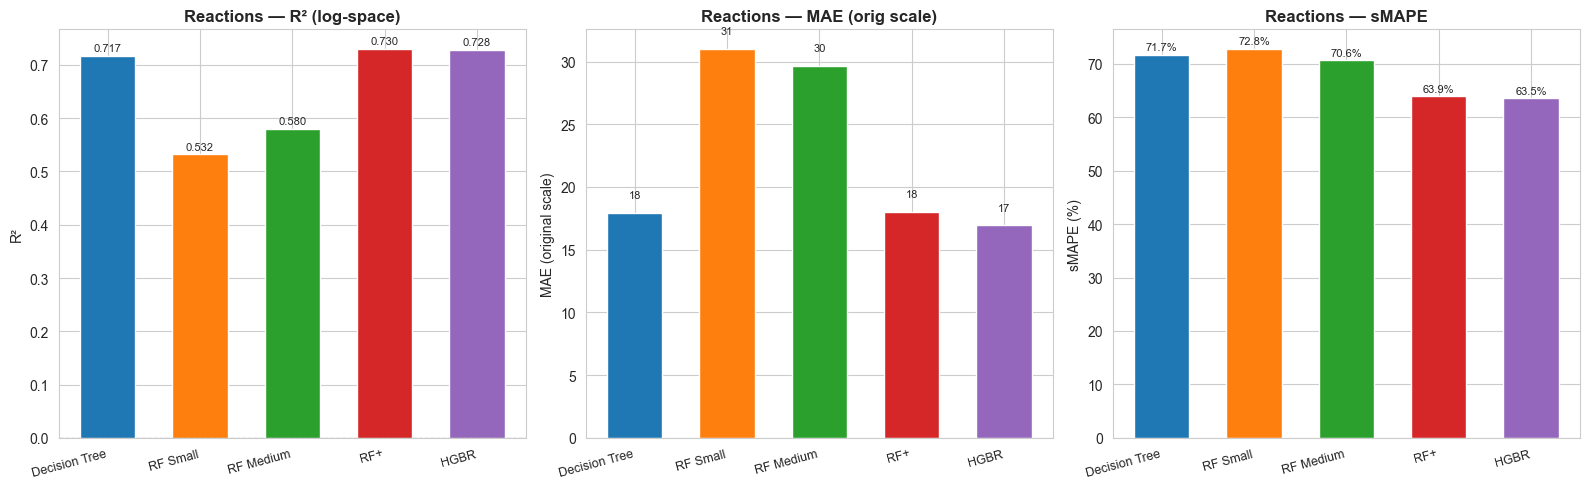

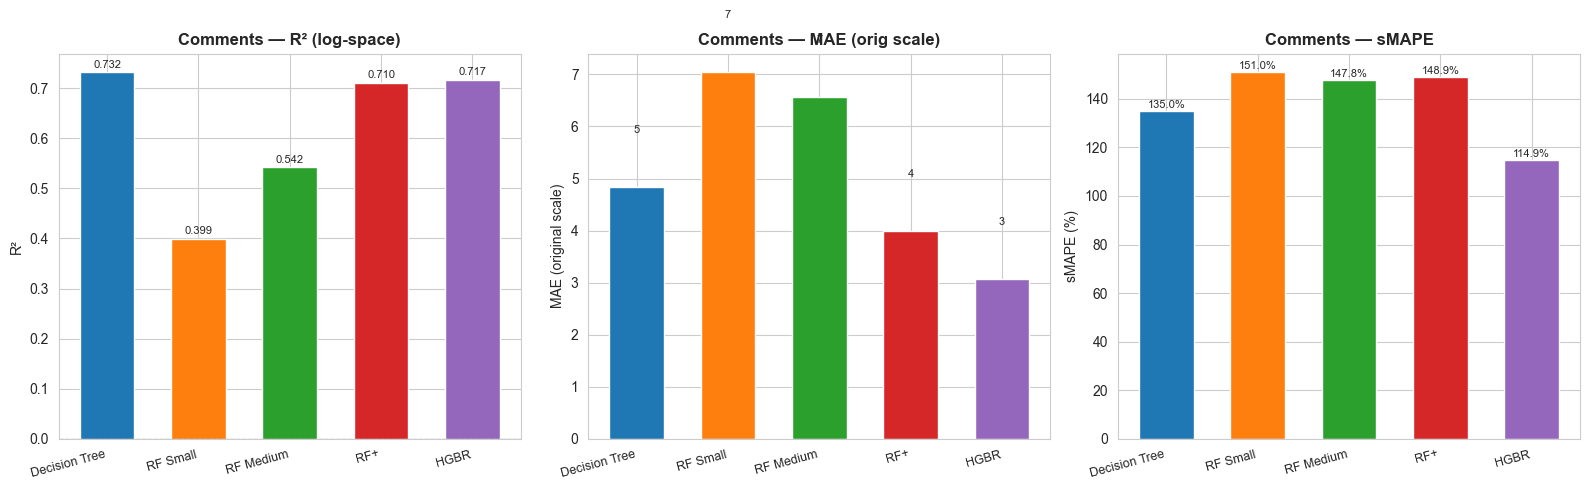

In [16]:
def plot_comparison(results, target_name, color_palette=None):
    labels = [r['label'].split('(')[0].strip() for r in results]
    log_r2  = [r['log_r2'] for r in results]
    orig_r2 = [r['r2']     for r in results]
    mae     = [r['mae']    for r in results]
    smape_  = [r['smape']  for r in results]

    n = len(results)
    if color_palette is None or len(color_palette) < n:
        color_palette = list(plt.cm.tab10.colors[:n])

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    x = np.arange(n)

    bars0 = axes[0].bar(x, log_r2, color=color_palette, edgecolor='white', width=0.6)
    axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axes[0].set_xticks(x); axes[0].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[0].set_ylabel('R²')
    axes[0].set_title(f'{target_name} — R² (log-space)', fontweight='bold')
    for bar, v in zip(bars0, log_r2):
        axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    bars1 = axes[1].bar(x, mae, color=color_palette, edgecolor='white', width=0.6)
    axes[1].set_xticks(x); axes[1].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[1].set_ylabel('MAE (original scale)')
    axes[1].set_title(f'{target_name} — MAE (orig scale)', fontweight='bold')
    for bar, v in zip(bars1, mae):
        axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, f'{v:.0f}', ha='center', va='bottom', fontsize=8)

    bars2 = axes[2].bar(x, smape_, color=color_palette, edgecolor='white', width=0.6)
    axes[2].set_xticks(x); axes[2].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[2].set_ylabel('sMAPE (%)')
    axes[2].set_title(f'{target_name} — sMAPE', fontweight='bold')
    for bar, v in zip(bars2, smape_):
        axes[2].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_comparison(results_reactions, 'Reactions')
plot_comparison(results_comments,  'Comments')

Best reactions model by MAE: HGBR  (MAE=16.9  Log R²=0.7280)
Best comments  model by MAE: HGBR  (MAE=3.1  Log R²=0.7168)


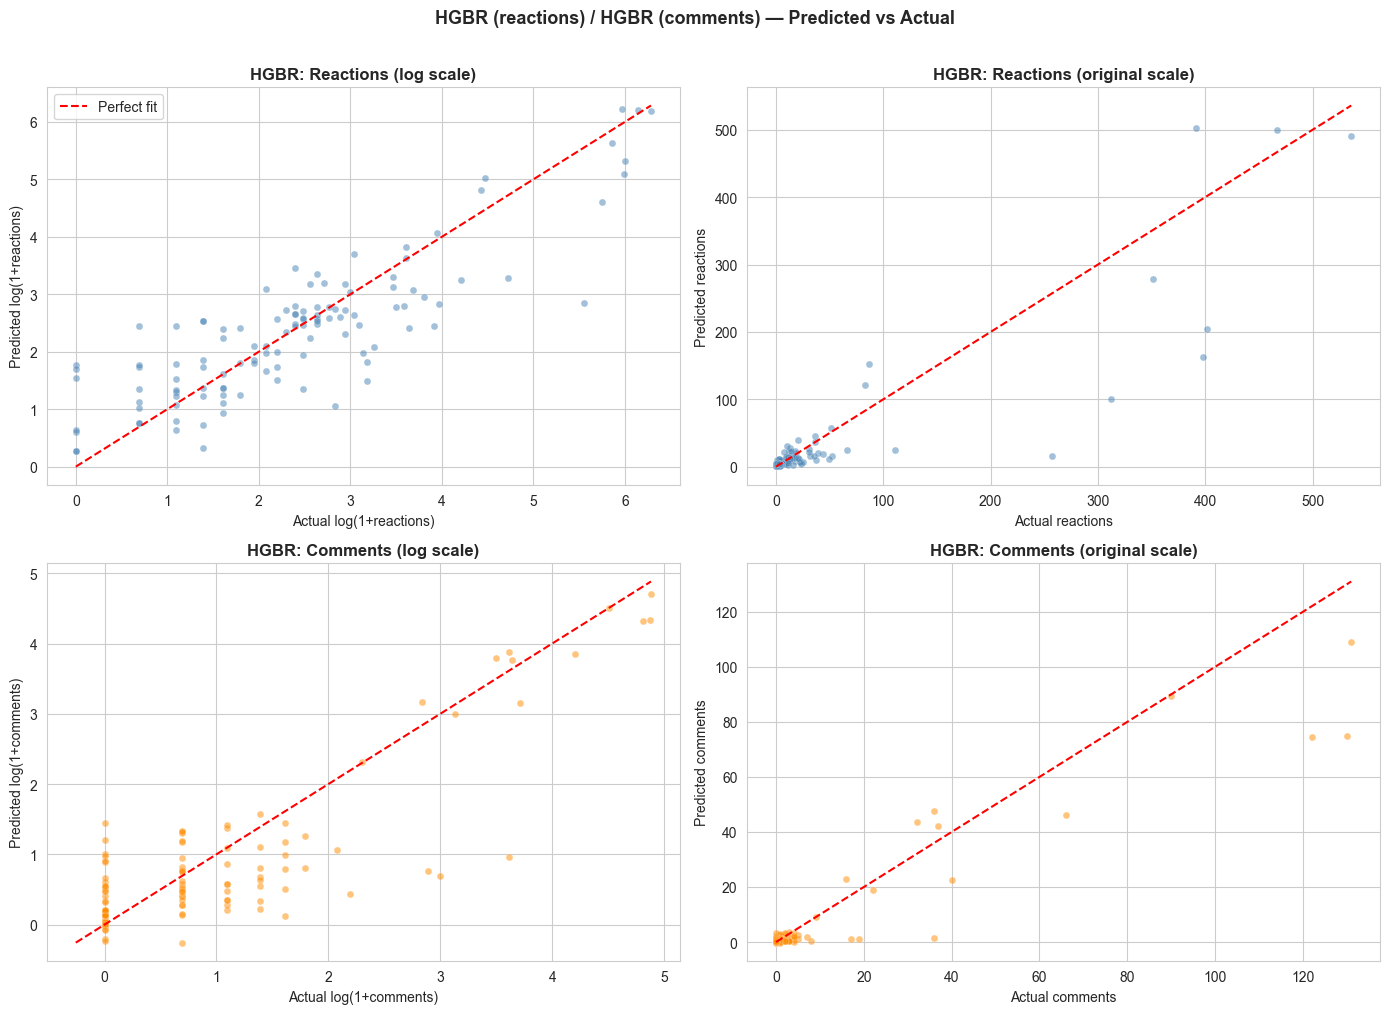

In [17]:
# Pick best model for each target by lowest MAE
best_r_entry = min(results_reactions, key=lambda r: r['mae'])
best_r_name  = best_r_entry['label'].split('(')[0].strip()
best_model_r = models_reactions[best_r_name]

best_c_entry = min(results_comments, key=lambda r: r['mae'])
best_c_name  = best_c_entry['label'].split('(')[0].strip()
best_model_c = models_comments[best_c_name]

print(f'Best reactions model by MAE: {best_r_name}  (MAE={best_r_entry["mae"]:.1f}  Log R²={best_r_entry["log_r2"]:.4f})')
print(f'Best comments  model by MAE: {best_c_name}  (MAE={best_c_entry["mae"]:.1f}  Log R²={best_c_entry["log_r2"]:.4f})')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

y_pred_r_log = best_model_r.predict(X_test_r)
y_pred_c_log = best_model_c.predict(X_test_c)
y_pred_r = np.expm1(y_pred_r_log)
y_pred_c = np.expm1(y_pred_c_log)

# Log scale — reactions
axes[0,0].scatter(yr_test, y_pred_r_log, alpha=0.5, s=25, color='steelblue', edgecolors='white', linewidths=0.3)
lims = [min(yr_test.min(), y_pred_r_log.min()), max(yr_test.max(), y_pred_r_log.max())]
axes[0,0].plot(lims, lims, 'r--', lw=1.5, label='Perfect fit')
axes[0,0].set_xlabel('Actual log(1+reactions)'); axes[0,0].set_ylabel('Predicted log(1+reactions)')
axes[0,0].set_title(f'{best_r_name}: Reactions (log scale)', fontweight='bold')
axes[0,0].legend()

# Original scale — reactions
axes[0,1].scatter(yr_test_raw, y_pred_r, alpha=0.5, s=25, color='steelblue', edgecolors='white', linewidths=0.3)
lims = [0, max(yr_test_raw.max(), y_pred_r.max())]
axes[0,1].plot(lims, lims, 'r--', lw=1.5)
axes[0,1].set_xlabel('Actual reactions'); axes[0,1].set_ylabel('Predicted reactions')
axes[0,1].set_title(f'{best_r_name}: Reactions (original scale)', fontweight='bold')

# Log scale — comments
axes[1,0].scatter(yc_test, y_pred_c_log, alpha=0.5, s=25, color='darkorange', edgecolors='white', linewidths=0.3)
lims = [min(yc_test.min(), y_pred_c_log.min()), max(yc_test.max(), y_pred_c_log.max())]
axes[1,0].plot(lims, lims, 'r--', lw=1.5)
axes[1,0].set_xlabel('Actual log(1+comments)'); axes[1,0].set_ylabel('Predicted log(1+comments)')
axes[1,0].set_title(f'{best_c_name}: Comments (log scale)', fontweight='bold')

# Original scale — comments
axes[1,1].scatter(yc_test_raw, y_pred_c, alpha=0.5, s=25, color='darkorange', edgecolors='white', linewidths=0.3)
lims = [0, max(yc_test_raw.max(), y_pred_c.max())]
axes[1,1].plot(lims, lims, 'r--', lw=1.5)
axes[1,1].set_xlabel('Actual comments'); axes[1,1].set_ylabel('Predicted comments')
axes[1,1].set_title(f'{best_c_name}: Comments (original scale)', fontweight='bold')

plt.suptitle(f'{best_r_name} (reactions) / {best_c_name} (comments) — Predicted vs Actual',
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Section 7. Feature Importance

  Computing permutation importance for HGBR Feature Importance...


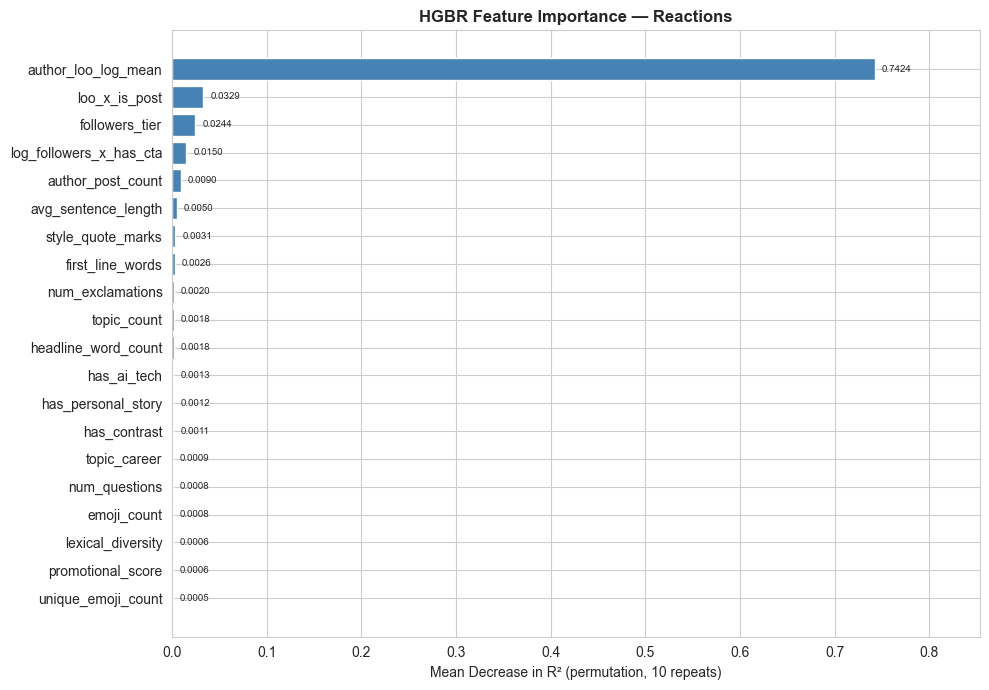

  Computing permutation importance for HGBR Feature Importance...


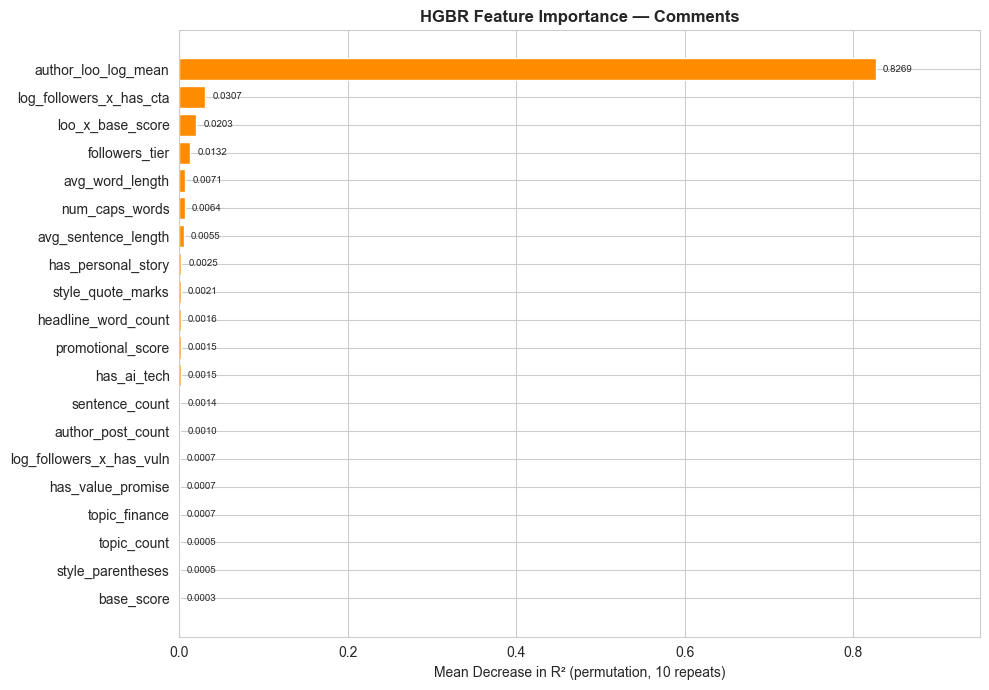

In [18]:
def plot_importance(model, feature_names, title, color='steelblue', top_n=20, X=None, y=None):
    if hasattr(model, 'feature_importances_'):
        imp = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False).head(top_n)
        xlabel = 'Mean Decrease in Impurity (MDI)'
    else:
        assert X is not None and y is not None, "X and y required for permutation importance"
        print(f"  Computing permutation importance for {title.split('—')[0].strip()}...")
        result = permutation_importance(model, X, y, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
        imp = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False).head(top_n)
        xlabel = 'Mean Decrease in R² (permutation, 10 repeats)'

    fig, ax = plt.subplots(figsize=(10, 7))
    imp_sorted = imp.sort_values()
    bars = ax.barh(imp_sorted.index, imp_sorted.values, color=color, edgecolor='white')
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlim(0, imp_sorted.values.max() * 1.15)
    for bar, v in zip(bars, imp_sorted.values):
        ax.text(v + imp_sorted.values.max()*0.01, bar.get_y()+bar.get_height()/2,
                f'{v:.4f}', va='center', fontsize=7)
    plt.tight_layout()
    plt.show()

plot_importance(best_model_r, feature_names_r, f'{best_r_name} Feature Importance — Reactions',
                color='steelblue',  X=X_test_r, y=yr_test)
plot_importance(best_model_c, feature_names_c, f'{best_c_name} Feature Importance — Comments',
                color='darkorange', X=X_test_c, y=yc_test)

## Section 8. Decision Tree Visualization

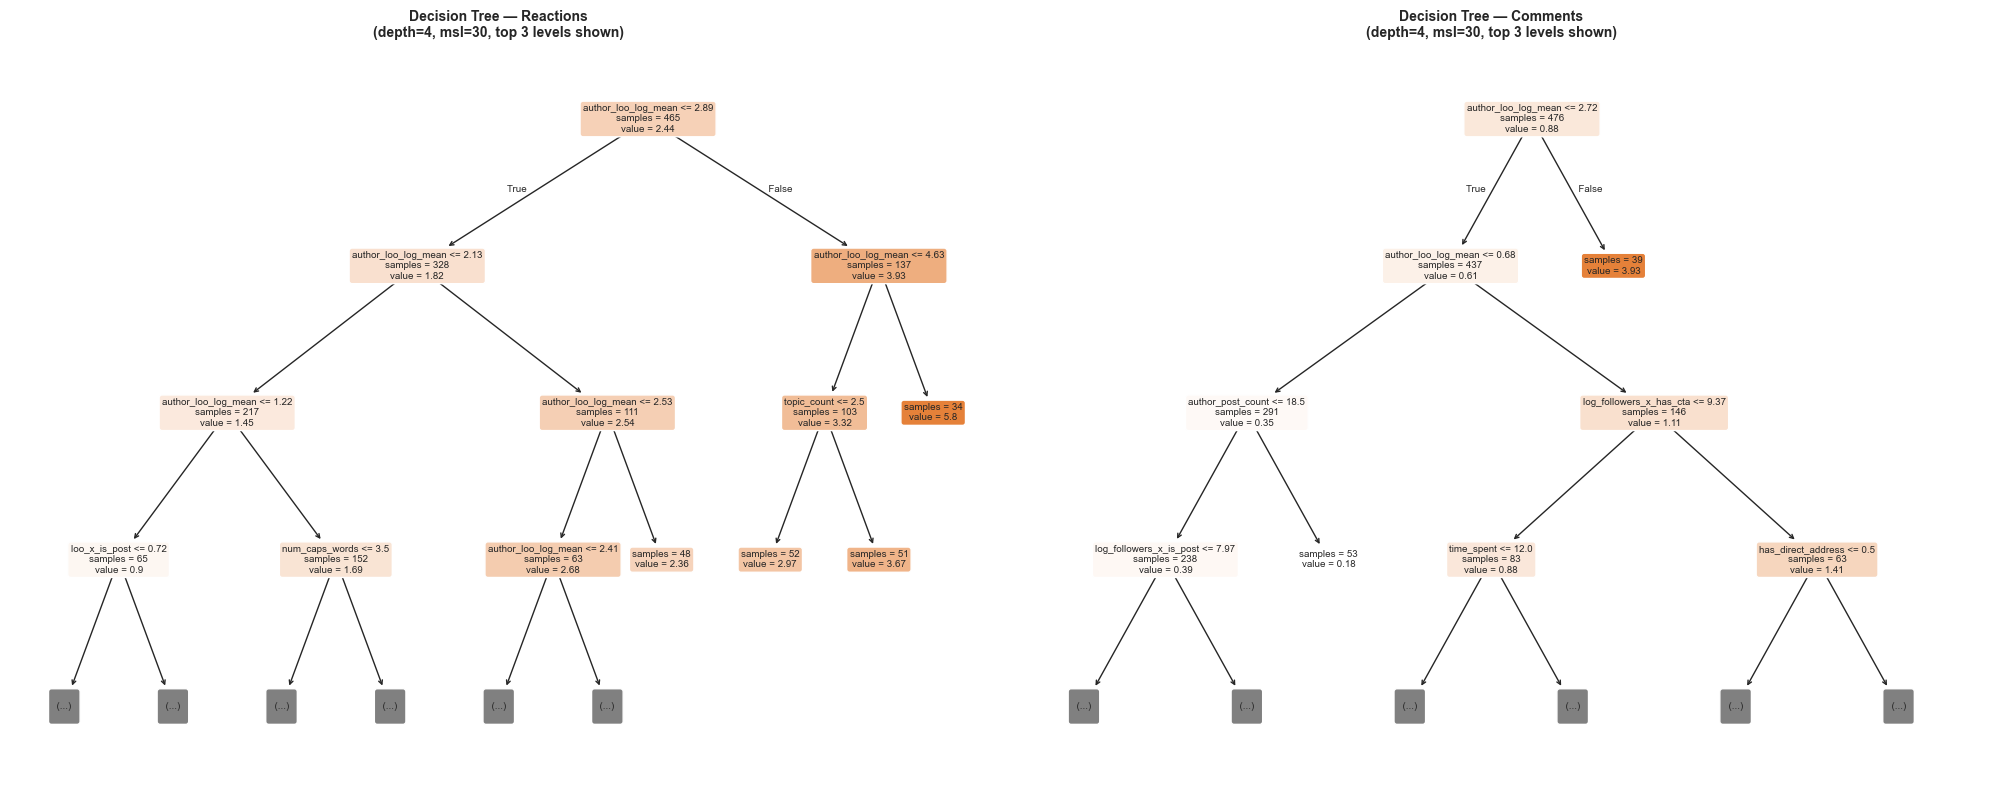

Decision Tree Rules (Reactions, max depth 4):
|--- author_loo_log_mean <= 2.89
|   |--- author_loo_log_mean <= 2.13
|   |   |--- author_loo_log_mean <= 1.22
|   |   |   |--- loo_x_is_post <= 0.72
|   |   |   |   |--- value: [1.31]
|   |   |   |--- loo_x_is_post >  0.72
|   |   |   |   |--- value: [0.54]
|   |   |--- author_loo_log_mean >  1.22
|   |   |   |--- num_caps_words <= 3.50
|   |   |   |   |--- value: [1.35]
|   |   |   |--- num_caps_words >  3.50
|   |   |   |   |--- value: [1.85]
|   |--- author_loo_log_mean >  2.13
|   |   |--- author_loo_log_mean <= 2.53
|   |   |   |--- author_loo_log_mean <= 2.41
|   |   |   |   |--- value: [2.40]
|   |   |   |--- author_loo_log_mean >  2.41
|   |   |   |   |--- value: [2.94]
|   |   |--- author_loo_log_mean >  2.53
|   |   |   |--- value: [2.36]
|--- author_loo_log_mean >  2.89
|   |--- author_loo_log_mean <= 4.63
|   |   |--- topic_count <= 2.50
|   |   |   |--- value: [2.97]
|   |   |--- topic_count >  2.50
|   |   |   |--- value: [3.

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

plot_tree(dt, feature_names=feature_names_r, ax=axes[0],
          filled=True, rounded=True, fontsize=7, max_depth=3,
          class_names=None, impurity=False, precision=2)
axes[0].set_title('Decision Tree — Reactions\n(depth=4, msl=30, top 3 levels shown)',
                   fontweight='bold', fontsize=10)

plot_tree(dt_c, feature_names=feature_names_c, ax=axes[1],
          filled=True, rounded=True, fontsize=7, max_depth=3,
          class_names=None, impurity=False, precision=2)
axes[1].set_title('Decision Tree — Comments\n(depth=4, msl=30, top 3 levels shown)',
                  fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print('Decision Tree Rules (Reactions, max depth 4):')
print(export_text(dt, feature_names=feature_names_r, max_depth=4))

## Section 9. Results Summary Table

In [20]:
print('='*80)
print('FINAL RESULTS SUMMARY')
print('='*80)

def summary_df(results):
    rows = []
    for r in results:
        rows.append({
            'Model': r['label'],
            'Log R²': round(r['log_r2'], 4),
            'Log MAE': round(r['log_mae'], 4),
            'MAE (orig)': round(r['mae'], 1),
            'RMSE (orig)': round(r['rmse'], 1),
            'R² (orig)': round(r['r2'], 4),
            'sMAPE (%)': round(r['smape'], 1),
            'MedAE (orig)': round(r['medae'], 1),
            'Spearman ρ': round(r['spearman_rho'], 4),
        })
    return pd.DataFrame(rows).set_index('Model')

print(f'\nFeatures used — Reactions: {len(feature_names_r)}  Comments: {len(feature_names_c)}')

print('\nREACTIONS:')
df_r = summary_df(results_reactions)
print(df_r.to_string())

print('\nCOMMENTS:')
df_c = summary_df(results_comments)
print(df_c.to_string())

best_r = df_r['Log R²'].idxmax()
best_c = df_c['Log R²'].idxmax()
print(f'\nBest for reactions: {best_r}  (Log R²={df_r.loc[best_r, "Log R²"]}  Spearman ρ={df_r.loc[best_r, "Spearman ρ"]})')
print(f'Best for comments:  {best_c}  (Log R²={df_c.loc[best_c, "Log R²"]}  Spearman ρ={df_c.loc[best_c, "Spearman ρ"]})')

FINAL RESULTS SUMMARY

Features used — Reactions: 81  Comments: 83

REACTIONS:
                                         Log R²  Log MAE  MAE (orig)  RMSE (orig)  R² (orig)  sMAPE (%)  MedAE (orig)  Spearman ρ
Model                                                                                                                            
Decision Tree (depth=4, msl=30)          0.7165   0.6072        17.9         47.3     0.7700       71.7           3.4      0.7717
RF Small (depth=4, msl=30, MAE)          0.5323   0.7199        31.0         94.1     0.0897       72.8           3.8      0.7549
RF Medium (depth=5, msl=20, MAE)         0.5801   0.6835        29.7         89.7     0.1732       70.6           3.6      0.7640
RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)  0.7302   0.5556        18.0         53.6     0.7046       63.9           3.1      0.8057
HGBR (MAE loss, lr=0.05, iter=500)       0.7280   0.5485        16.9         45.5     0.7873       63.5           3.6      0.8058

COMMENTS:


## Section 10. Predict on New Sample

In [21]:
def predict_engagement(
    followers=10_000,
    connections=500,
    time_spent=30,
    num_hashtags=3,
    media_type='post',
    content="Excited to share that I've just been promoted to Senior Engineer! This journey has been incredible.",
    headline='Senior Software Engineer',
    num_content_links=0,
):
    """
    Predict reactions and comments for a new LinkedIn post.
    Author baseline always uses the global LOO mean — author identity
    is not available at inference time.
    Each model uses its own LOO stats (reactions-based vs comments-based).
    Sample index is set to -1 so it never collides with training-set indices
    in the per-row LOO lookup, triggering the global-mean fallback correctly.
    """
    sample = pd.DataFrame(
        [{
            'followers':     followers,
            'connections':   connections,
            'time_spent':    time_spent,
            'num_hashtags':  num_hashtags,
            'media_type':    media_type,
            'content':       content,
            'headline':      headline,
            'content_links': np.nan if num_content_links == 0 else '; '.join(['http://example.com'] * num_content_links),
            'hashtags':      np.nan,
            'name':          '__unknown__',
        }],
        index=[-1]   # sentinel — not in any training-set LOO per-row dict
    )

    # Reactions model
    X_new_r = engineer_features(sample, loo_stats_r).fillna(0)
    for col in feature_names_r:
        if col not in X_new_r.columns:
            X_new_r[col] = 0
    X_new_r = X_new_r[feature_names_r]

    # Comments model
    X_new_c = engineer_features(sample, loo_stats_c).fillna(0)
    for col in feature_names_c:
        if col not in X_new_c.columns:
            X_new_c[col] = 0
    X_new_c = X_new_c[feature_names_c]

    pred_r_log = best_model_r.predict(X_new_r)[0]
    pred_c_log = rf_plus_c.predict(X_new_c)[0]
    pred_reactions = max(0, np.expm1(pred_r_log))
    pred_comments  = max(0, np.expm1(pred_c_log))

    print(f"{followers:,} followers  |  {media_type}  |  {num_hashtags} hashtags")
    print(f"  Predicted reactions: {pred_reactions:.0f}  (log={pred_r_log:.3f})")
    print(f"  Predicted comments:  {pred_comments:.0f}   (log={pred_c_log:.3f})")
    return pred_reactions, pred_comments

print(f"predict_engagement uses: reactions={best_r_name}  comments=RF+\n")

# ── Example 1: Large account, personal vulnerability story ────────────────────
print("--- Example 1: Large account, personal story ---")
predict_engagement(
    followers=150_000, num_hashtags=5, media_type='post',
    content='After 10 years I finally failed. And that failure taught me everything. I was scared to share this but here it is...'
)

# ── Example 2: Mid-size account, article ──────────────────────────────────────
print("\n--- Example 2: Mid-size account, article ---")
predict_engagement(
    followers=25_000, num_hashtags=4, media_type='article',
    content='How AI is transforming enterprise software. What every CTO needs to know about machine learning adoption in 2025.'
)

# ── Example 3: Small account, announcement ────────────────────────────────────
print("\n--- Example 3: Small account, announcement post ---")
predict_engagement(
    followers=8_000, num_hashtags=2, media_type='post',
    content="Excited to share that I've just been promoted to Senior Engineer! This journey has been incredible."
)

predict_engagement uses: reactions=HGBR  comments=RF+

--- Example 1: Large account, personal story ---
150,000 followers  |  post  |  5 hashtags
  Predicted reactions: 26  (log=3.281)
  Predicted comments:  2   (log=1.167)

--- Example 2: Mid-size account, article ---
25,000 followers  |  article  |  4 hashtags
  Predicted reactions: 19  (log=3.013)
  Predicted comments:  1   (log=0.672)

--- Example 3: Small account, announcement post ---
8,000 followers  |  post  |  2 hashtags
  Predicted reactions: 16  (log=2.827)
  Predicted comments:  1   (log=0.643)


(15.890930921170792, 0.902405461303437)

## Section 11. Save HGBR Models for Streamlit

In [ ]:
import joblib
import json
import os
from datetime import datetime

# ── Save directory ─────────────────────────────────────────────────────────────
SAVE_DIR = '../models/hgbr_streamlit'
os.makedirs(SAVE_DIR, exist_ok=True)

# ── 1. Save HGBR models ────────────────────────────────────────────────────────
joblib.dump(hgbr,   f'{SAVE_DIR}/hgbr_reactions.pkl')
joblib.dump(hgbr_c, f'{SAVE_DIR}/hgbr_comments.pkl')
print(f'✓ hgbr_reactions.pkl  (MAE loss, lr=0.05, iter=500)')
print(f'✓ hgbr_comments.pkl   (MAE loss, lr=0.05, iter=500)')

# ── 2. Save feature name lists ─────────────────────────────────────────────────
with open(f'{SAVE_DIR}/feature_names_reactions.json', 'w') as f:
    json.dump(feature_names_r, f, indent=2)

with open(f'{SAVE_DIR}/feature_names_comments.json', 'w') as f:
    json.dump(feature_names_c, f, indent=2)

print(f'✓ feature_names_reactions.json  ({len(feature_names_r)} features)')
print(f'✓ feature_names_comments.json   ({len(feature_names_c)} features)')

# ── 3. Save LOO author stats (needed to score new posts at inference time) ──────
# Convert numpy scalars / arrays to plain Python so json.dump works
def _loo_to_serialisable(stats):
    return {
        'loo_log_mean':   {k: float(v) for k, v in stats['loo_log_mean'].items()},
        'loo_log_median': {k: float(v) for k, v in stats['loo_log_median'].items()},
        'post_count':     {k: int(v)   for k, v in stats['post_count'].items()},
        'global_log_mean':   float(stats['global_log_mean']),
        'global_log_median': float(stats['global_log_median']),
        # per-row dicts have integer keys (df index); store as str for JSON
        'loo_log_mean_per_row':   {str(k): float(v) for k, v in stats['loo_log_mean_per_row'].items()},
        'loo_log_median_per_row': {str(k): float(v) for k, v in stats['loo_log_median_per_row'].items()},
    }

with open(f'{SAVE_DIR}/loo_stats_reactions.json', 'w') as f:
    json.dump(_loo_to_serialisable(loo_stats_r), f, indent=2)

with open(f'{SAVE_DIR}/loo_stats_comments.json', 'w') as f:
    json.dump(_loo_to_serialisable(loo_stats_c), f, indent=2)

print(f'✓ loo_stats_reactions.json')
print(f'✓ loo_stats_comments.json')

# ── 4. Save model metadata ─────────────────────────────────────────────────────
# Re-evaluate on held-out test set to record metrics alongside the artefacts
hgbr_metrics_r = evaluate(yr_test, hgbr.predict(X_test_r),   yr_test_raw, 'HGBR reactions')
hgbr_metrics_c = evaluate(yc_test, hgbr_c.predict(X_test_c), yc_test_raw, 'HGBR comments')

metadata = {
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'HistGradientBoostingRegressor',
    'target_transform': 'log1p (log(1+y)); predictions back-transformed with expm1',
    'reactions': {
        'file': 'hgbr_reactions.pkl',
        'params': {'loss': 'absolute_error', 'learning_rate': 0.05, 'max_iter': 500,
                   'max_depth': 6, 'min_samples_leaf': 20, 'l2_regularization': 0.1},
        'n_features': len(feature_names_r),
        'feature_names_file': 'feature_names_reactions.json',
        'loo_stats_file': 'loo_stats_reactions.json',
        'test_metrics': {k: (float(v) if isinstance(v, (np.floating, float)) else v)
                         for k, v in hgbr_metrics_r.items() if k != 'label'},
    },
    'comments': {
        'file': 'hgbr_comments.pkl',
        'params': {'loss': 'absolute_error', 'learning_rate': 0.05, 'max_iter': 500,
                   'max_depth': 6, 'min_samples_leaf': 20, 'l2_regularization': 0.1},
        'n_features': len(feature_names_c),
        'feature_names_file': 'feature_names_comments.json',
        'loo_stats_file': 'loo_stats_comments.json',
        'test_metrics': {k: (float(v) if isinstance(v, (np.floating, float)) else v)
                         for k, v in hgbr_metrics_c.items() if k != 'label'},
    },
}

with open(f'{SAVE_DIR}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f'✓ metadata.json')

print(f'\n{"="*60}')
print(f'All artefacts saved to: {SAVE_DIR}/')
print(f'{"="*60}')
print(f'\nReactions HGBR  — Log R²: {hgbr_metrics_r["log_r2"]:.4f}  MAE: {hgbr_metrics_r["mae"]:.1f}  sMAPE: {hgbr_metrics_r["smape"]:.1f}%')
print(f'Comments  HGBR  — Log R²: {hgbr_metrics_c["log_r2"]:.4f}  MAE: {hgbr_metrics_c["mae"]:.1f}  sMAPE: {hgbr_metrics_c["smape"]:.1f}%')
print(f'\nStreamlit usage:')
print(f'  import joblib, json')
print(f'  hgbr_r = joblib.load("{SAVE_DIR}/hgbr_reactions.pkl")')
print(f'  hgbr_c = joblib.load("{SAVE_DIR}/hgbr_comments.pkl")')
print(f'  feat_r = json.load(open("{SAVE_DIR}/feature_names_reactions.json"))')
print(f'  feat_c = json.load(open("{SAVE_DIR}/feature_names_comments.json"))')
print(f'  loo_r  = json.load(open("{SAVE_DIR}/loo_stats_reactions.json"))')
print(f'  loo_c  = json.load(open("{SAVE_DIR}/loo_stats_comments.json"))')


✓ hgbr_reactions.pkl  (MAE loss, lr=0.05, iter=500)
✓ hgbr_comments.pkl   (MAE loss, lr=0.05, iter=500)
✓ feature_names_reactions.json  (81 features)
✓ feature_names_comments.json   (83 features)
✓ loo_stats_reactions.json
✓ loo_stats_comments.json
✓ metadata.json

All artefacts saved to: ../models/hgbr_streamlit/

Reactions HGBR  — Log R²: 0.7280  MAE: 16.9  sMAPE: 63.5%
Comments  HGBR  — Log R²: 0.7168  MAE: 3.1  sMAPE: 114.9%

Streamlit usage:
  import joblib, json
  hgbr_r = joblib.load("../models/hgbr_streamlit/hgbr_reactions.pkl")
  hgbr_c = joblib.load("../models/hgbr_streamlit/hgbr_comments.pkl")
  feat_r = json.load(open("../models/hgbr_streamlit/feature_names_reactions.json"))
  feat_c = json.load(open("../models/hgbr_streamlit/feature_names_comments.json"))
  loo_r  = json.load(open("../models/hgbr_streamlit/loo_stats_reactions.json"))
  loo_c  = json.load(open("../models/hgbr_streamlit/loo_stats_comments.json"))
